# Inverted pendulum on a cart
Learning about control systems by building a classic!

The youtube series ['Control Bootcamp' by Steve Brunton](https://www.youtube.com/playlist?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m) is really fantastic. His book [Data Driven Science and Engineering](http://databookuw.com/databook.pdf) is also great (well, the parts ive looked at so far have been!) This project is an attempt to understand the content, translate the lessons from Matlab to Python and eventually build a real inverted pendulum!

## Regurgitated Theory
Note that for a full understanding, you should really watch the videos and read the text book yourself. This is just my (poor) attempt to re-write it in my own words to try and prove to myself that I understand what is happening.

![](assets\schematic.png)

The non-linear dynamics of this system are given by:

$$\dot{x} = v$$
$$\dot{v} = \frac{−m^2L^2g cos(θ) sin(θ) + mL^2(mLω^2sin(θ) − δv) + mL^2u}{mL^2(M + m(1 − cos(θ)^2))}$$
$$\dot{\Theta} = \omega $$
$$\dot{\omega} = \frac{(m + M)mgL sin(θ) − mL cos(θ)(mLω^2
sin(θ) − δv) + mL cos(θ)u}{mL^2(M + m(1 − cos(θ)^2)) }$$

where $x$ is the cart position, $v$ is the velocity, $θ$ is the pendulum  angle, $ω$ is the angular velocity, $m$ is the pendulum mass, $M$ is the cart mass, $L$ is the pendulum arm, $g$ is the gravitational acceleration, $δ$ is a friction damping on the dart, and $u$ is a control force applied to the cart.

We really care about $u$! Lets take a look at the system *without* $u$. To start with, lets import everything we need:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import control as control

Next, we define the physical constants of our model:

In [7]:
m = 1 # pendulum mass
M = 5 # cart mass
L = 2 # length of the pendulum arm
g = -9.8 # acceleration of gravity 
d = 1 # friction damping

To simulate the system, we will need to define the rhs function, and then numerically solve the differential equations:

In [8]:
def odes(state, t):
    x = state[0] # positon, note that this is a free variable
    x_dot = state[1] # velocity
    theta = state[2] # angle
    theta_dot = state[3] # angular velocity

    # zero out the controller for now
    u = 0

    Sx = np.sin(theta)
    Cx = np.cos(theta)
    D = m*L*L*(M+m*(1-Cx**2))

    dx = np.array([x_dot, 
         (1/D)*(-m**2*L**2*g*Cx*Sx + m*L**2*(m*L*theta_dot**2*Sx - d*x_dot)) + m*L*L*(1/D)*u,
         theta_dot,
         (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*theta_dot**2*Sx - d*x_dot)) - m*L*Cx*(1/D)*u])

    return dx

Note that the convention for control systems wizards seems to be to use dot notation to indicate derivates, ie:
$$\dot{y} = \frac{dy}{dt}$$
So, lets solve the differential equations and plot the results:

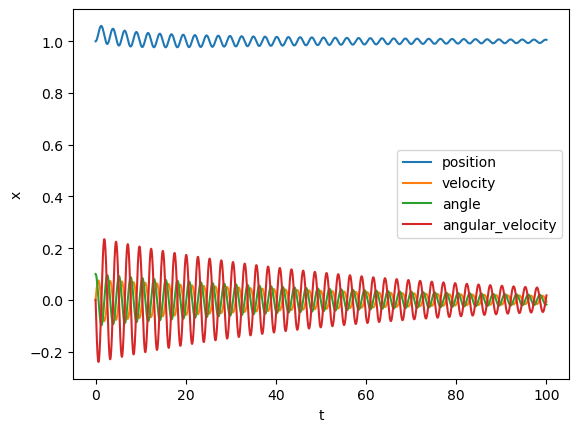

In [12]:
# initial conditions
x0 = np.array([1, 0, 0.1, 0])
t = np.linspace(0, 100, 10000)
x = odeint(odes, x0, t)

# extract out the data
position = x[:,0]
velocity = x[:,1]
angle = x[:,2]
angular_velocity = x[:,3] 

fig,ax = plt.subplots()
ax.plot(t, position, label='position')
ax.plot(t, velocity, label='velocity')
ax.plot(t, angle, label='angle')
ax.plot(t, angular_velocity, label='angular_velocity')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

This seems to make intuitive sense. We start the pendulum with an initial angle slightly away from a fixed point (more on this later) and some arbitrary initial position of the cart ($\Theta=0.1, x=1$), then see how the dynamics play out. You can see from the figure above that there is some sort of exponentially decaying periodic wave. This makes sense! As the pendulum is 'released', it will swing back but with slightly less energy than when it started (sorry perpetual motion fan). Rinse and repeat for each swing and eventully the pendulum will come to rest at $\Theta=0$.  

Lets add a controller, and try to explain what we are doing as we go.

First, lets re-work the rhs function to accept a controller rather than hardcoding u=0. To check we havent broken anything, lets pass in the same u=0 controller.

In [15]:
def odes(state, t, controller):
    x = state[0] # positon, note that this is a free variable
    x_dot = state[1] # velocity
    theta = state[2] # angle
    theta_dot = state[3] # angular velocity

    u = controller(state) # we get u by applying the controller to our current state

    Sx = np.sin(theta)
    Cx = np.cos(theta)
    D = m*L*L*(M+m*(1-Cx**2))

    dx = np.array([x_dot, 
         (1/D)*(-m**2*L**2*g*Cx*Sx + m*L**2*(m*L*theta_dot**2*Sx - d*x_dot)) + m*L*L*(1/D)*u,
         theta_dot,
         (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*theta_dot**2*Sx - d*x_dot)) - m*L*Cx*(1/D)*u])

    return dx

x0 = np.array([1, 0, 0.1, 0])
t = np.linspace(0, 100, 10000)
controller = lambda x: 0
x = odeint(odes, x0, t, args=(controller,)) # note that we are passing in the controller now 

If we plot the results, we should get the same results as before. Lets write a function to make plotting a little easier:

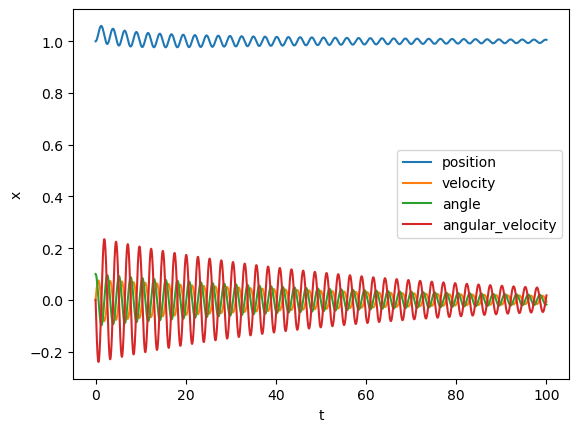

In [16]:
def plot_pendulum(state_vectors):
    position = state_vectors[:,0]
    velocity = state_vectors[:,1]
    angle = state_vectors[:,2]
    angular_velocity = state_vectors[:,3] 

    fig,ax = plt.subplots()
    ax.plot(t, position, label='position')
    ax.plot(t, velocity, label='velocity')
    ax.plot(t, angle, label='angle')
    ax.plot(t, angular_velocity, label='angular_velocity')
    ax.legend()
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

plot_pendulum(x)

So far so good!

Now, how do we design controller? 